# 🧭 Planning Pattern


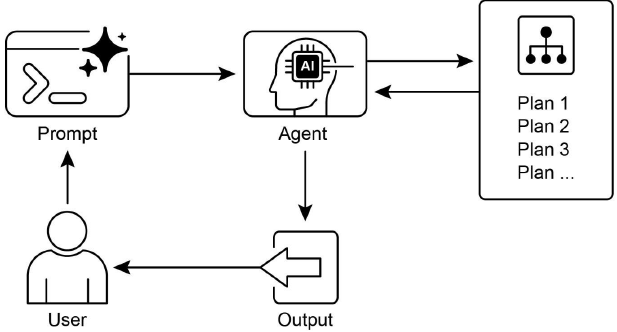

### **What**
The **Planning Pattern** enables an agent to decompose a complex goal into a structured sequence of smaller, executable actions.  
Rather than following a fixed workflow, the agent autonomously determines **how** to achieve the **what** (the goal).

---

### **How it Works**
1. Understands **initial state** and **goal state**.  
2. **Generates a plan** — a sequence of actions or steps.  
3. **Executes the plan** while adapting to new information or constraints.  
4. **Replans dynamically** if obstacles arise (e.g., unavailable resources).

---


In [1]:
from typing import Annotated, TypedDict, Any, Optional
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, RemoveMessage, AnyMessage
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import START, END, StateGraph, MessagesState, add_messages
from langgraph.prebuilt import ToolNode
from langgraph.errors import InvalidUpdateError

from IPython.display import display, Image

import operator
from datetime import datetime

from langchain_tavily import TavilySearch

In [2]:
load_dotenv()

True

In [3]:
llm = ChatOpenAI(
    model="/gpfs/projects/bsc02/llm_models/huggingface_models/Qwen3-32B",
    openai_api_key="dummy",  # vLLM doesn't need a real key
    openai_api_base="http://localhost:8002/v1",  # Your forwarded port
    temperature=0.7,
    max_tokens=500
)

In [4]:
tavily = TavilySearch(max_results=5)

### 1. Define Agent State

In [5]:
# ---------------------- Agent State Definition ----------------------
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    music_event_recommendations: Optional[list[str]]
    event_info_list: Optional[list[str]]
    next_node: Optional[str]
    excluded_events: Optional[list[str]]

### 2. Define Agent Nodes

In [6]:
# ---------------------- Node 1: Planner ----------------------
def planner_node(state: AgentState):
    """Generates plan for search and execution."""
    print("\n[PLANNER NODE] - Generating plan...")
    user_query = state["messages"][0].content
    today_date = datetime.now().strftime("%B %d, %Y")

    prompt = (
        f"Today's date is {today_date}. "
        f"You are a helpful planner agent. Create a concise plan to answer the following user query by searching the internet "
        f"and gathering factual details:\n\n"
        f"User Query: {user_query}\n\n"
        f"Keep the plan brief, outlining the steps or information categories to collect."
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    print("[PLANNER NODE] - Plan generated.")
    return {
        "messages": [response],
        "music_event_recommendations": None,
        "event_info_list": None,
        "next_node": "recommendation",
        "excluded_events": state.get("excluded_events", []),
    }

In [7]:
# ---------------------- Node 2: Recommendation ----------------------
def recommendation_node(state: AgentState):
    """Generates top recommendations (events, topics, etc.) using LLM."""
    print("\n[RECOMMENDATION NODE] - Generating top recommendations...")
    user_query = state["messages"][0].content
    plan_text = state["messages"][-1].content
    today_date = datetime.now().strftime("%B %d, %Y")
    excluded = state.get("excluded_events", [])

    prompt = (
        f"Today's date is {today_date}. "
        f"Based on this plan and user query, recommend 3 specific items (e.g., events, options, results) relevant to the query. "
        f"Do not include any from this exclusion list: {excluded if excluded else 'None'}.\n\n"
        f"User Query: {user_query}\n\n"
        f"Plan:\n{plan_text}\n\n"
        "Return a numbered list of exactly 3 distinct recommendations."
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    recommended_text = response.content.strip()
    recommendations = [line.split(". ", 1)[1] for line in recommended_text.split('\n') if ". " in line]

    print(f"[RECOMMENDATION NODE] - Generated recommendations: {recommendations}")
    return {
        "messages": [AIMessage(content=recommended_text)],
        "music_event_recommendations": recommendations,
        "event_info_list": None,
        "next_node": "lookup",
        "excluded_events": excluded,
    }

In [8]:
# ---------------------- Node 3: Lookup (with Tavily) ----------------------
def lookup_node(state: AgentState):
    """Searches the web for factual information about recommendations."""
    print("\n[LOOKUP NODE] - Fetching real-world info using Tavily...")
    recommendations = state["music_event_recommendations"]
    event_info_list = []
    excluded = state.get("excluded_events", [])
    today_date = datetime.now().strftime("%B %d, %Y")

    if not recommendations:
        print("[LOOKUP NODE] - No recommendations provided, stopping workflow.")
        return {"next_node": "executor"}

    insufficient = False
    seen = set(excluded)

    for item in recommendations:
        if item in seen:
            print(f"[LOOKUP NODE] - Skipping excluded item: {item}")
            continue

        query = f"{item} {today_date}"
        print(f"[LOOKUP NODE] - Tavily search: {query}")
        try:
            results = tavily.invoke({"query": query})
            if results and "results" in results and results["results"]:
                top_result = results["results"][0]
                info = f"Title: {top_result['title']}\nURL: {top_result['url']}\nSnippet: {top_result['content'][:300]}..."
                event_info_list.append(info)
                print(f"[LOOKUP NODE] - Found info for '{item}'")
            else:
                info = f"No details found for {item}."
                event_info_list.append(info)
                insufficient = True
                seen.add(item)
                print(f"[LOOKUP NODE] - No info found for '{item}', added to excluded list.")
        except Exception as e:
            print(f"[LOOKUP NODE] - Tavily search failed for '{item}': {e}")
            insufficient = True
            seen.add(item)

    next_node = "recommendation" if insufficient else "executor"
    return {
        "messages": [],
        "music_event_recommendations": state["music_event_recommendations"],
        "event_info_list": event_info_list,
        "next_node": next_node,
        "excluded_events": list(seen),
    }

In [9]:
# ---------------------- Node 4: Executor ----------------------
def executor_node(state: AgentState):
    """Final output generation."""
    print("\n[EXECUTOR NODE] - Generating final summary...")
    recs = state["music_event_recommendations"]
    infos = state["event_info_list"]
    today_date = datetime.now().strftime("%B %d, %Y")

    summary = f"--- Final Results for {today_date} ---\n\n"
    for i, rec in enumerate(recs or []):
        details = infos[i] if infos and i < len(infos) else "No additional info found."
        summary += f"**{i+1}. {rec}**\n{details}\n\n"

    print("[EXECUTOR NODE] - Summary complete.")
    return {
        "messages": [AIMessage(content=summary.strip())],
        "music_event_recommendations": recs,
        "event_info_list": infos,
        "next_node": "executor",
        "excluded_events": state.get("excluded_events", []),
    }

In [10]:
# ---------------------- Decision Logic ----------------------
def decide_next_node(state):
    """Decide whether to replan or finalize."""
    if state.get("next_node") == "recommendation":
        return "recommendation"
    return "executor"

### 3. Build the LangGraph StateGraph

In [11]:
# ---------------------- Build Graph ----------------------
graph = StateGraph(AgentState)
graph.add_node("planner", planner_node)
graph.add_node("recommendation", recommendation_node)
graph.add_node("lookup", lookup_node)
graph.add_node("executor", executor_node)

graph.add_edge(START, "planner")
graph.add_edge("planner", "recommendation")
graph.add_edge("recommendation", "lookup")
graph.add_conditional_edges("lookup", decide_next_node, {"recommendation": "recommendation", "executor": "executor"})
graph.add_edge("executor", END)

app = graph.compile()

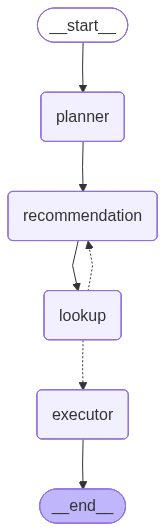

In [12]:
display(Image(app.get_graph().draw_mermaid_png()))

### 4. Run the Agent

In [17]:
# ---------------------- Run Agent ----------------------
user_input = input("Best irish music events and pubs in Barcelona tonight? ")


In [18]:
inputs = {
    "messages": [HumanMessage(content=user_input)],
    "music_event_recommendations": None,
    "event_info_list": None,
    "next_node": None,
    "excluded_events": [],
}

In [19]:
result = app.invoke(inputs)


[PLANNER NODE] - Generating plan...
[PLANNER NODE] - Plan generated.

[RECOMMENDATION NODE] - Generating top recommendations...
[RECOMMENDATION NODE] - Generated recommendations: ["The user wants the best Irish music events and pubs in Barcelona tonight, which is February 27, 2026. Since I can't access real-time data, I'll have to rely on existing knowledge and common venues in Barcelona that are known for Irish music.", "The most famous one is *The Irish Pub* in El Raval. They often host live sessions, especially around St. Patrick's Day, but even in February, they might have something going on. I should include that. ", "They're known for traditional music, and it's possible they have a scheduled event tonight. Checking their website or social media would be ideal, but since I can't do that, I'll assume they have regular sessions. ", "They sometimes feature live bands, so maybe there's an event tonight. ", "Let me make sure these are distinct and relevant. I should also mention any 

In [20]:
# Print final answer
print("\n=== FINAL OUTPUT ===")
print(result["messages"][-1].content)


=== FINAL OUTPUT ===
--- Final Results for February 27, 2026 ---

**1. The user wants the best Irish music events and pubs in Barcelona tonight, which is February 27, 2026. Since I can't access real-time data, I'll have to rely on existing knowledge and common venues in Barcelona that are known for Irish music.**
Title: The Michael Collins Irish Pub: Welcome
URL: https://michaelcollinspubs.com/
Snippet: The best Irish Pub in Barcelona! Live Music, Sports, Traditional Irish Music ... 9:00 pm, February 27, 2026 – WOLVES V ASTON VILLA; 11:30 pm, February 27...

**2. The most famous one is *The Irish Pub* in El Raval. They often host live sessions, especially around St. Patrick's Day, but even in February, they might have something going on. I should include that. **
Title: THE BEST 10 IRISH PUB near EL RAVAL, BARCELONA, SPAIN
URL: https://www.yelp.com/search?cflt=irish_pubs&find_loc=El+Raval%2C+Barcelona
Snippet: The Best 10 Irish Pub near El Raval, Barcelona, Spain · 1. Flaherty's Irish

## Small test on Tavilly output structure

In [21]:
today_date = datetime.now().strftime("%B %d, %Y")

In [26]:
query = f'live irish music events at a pub in Barcelona tonight {today_date}'

In [27]:
print(query)

live irish music events at a pub in Barcelona tonight February 27, 2026


In [28]:
test_results = tavily.invoke({"query": query})

In [29]:
test_results

{'query': 'live irish music events at a pub in Barcelona tonight February 27, 2026',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://michaelcollinspubs.com/events-calendar/?mc_id=4957',
   'title': 'Events Calendar | The Michael Collins Irish Pub',
   'content': 'The best Irish Pub in Barcelona! Live Music, Sports, Traditional Irish Music ... 27February 27, 2026○○(2 events) · 28February 28, 2026○○(8 events). Follow Us',
   'score': 0.9999808,
   'raw_content': None},
  {'url': 'https://www.tripadvisor.com/Attraction_Review-g187497-d23568894-Reviews-or10-The_Old_Irish_Pub_Barcelona-Barcelona_Catalonia.html',
   'title': 'The Old Irish Pub Barcelona (2026) - All You MUST Know Before ...',
   'content': '‣ Authentic Irish atmosphere ‣ Fantastic live music ‣ Sport events on big screens ‣ A broad selection of beer, liquor and cocktails ‣ Party and dancing on',
   'score': 0.99995315,
   'raw_content': None},
  {'url': 'https://templebarbcn.com/en'

In [30]:
# top result based on the score
test_results["results"][0]

{'url': 'https://michaelcollinspubs.com/events-calendar/?mc_id=4957',
 'title': 'Events Calendar | The Michael Collins Irish Pub',
 'content': 'The best Irish Pub in Barcelona! Live Music, Sports, Traditional Irish Music ... 27February 27, 2026○○(2 events) · 28February 28, 2026○○(8 events). Follow Us',
 'score': 0.9999808,
 'raw_content': None}